## **MODEL'S PIPELINE**

### **GENERAL IMPORTS**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore") 

### **DATA**

In [4]:
data_model = pd.read_csv("data/processed/data_model.csv")

# data_model["gender"] = data_model["gender"].astype("category")
data_model["registered_on"] = pd.to_datetime(data_model["registered_on"])

data_model = data_model.sort_values("registered_on").reset_index(drop=True)

print(data_model.shape)
data_model.head()

(63288, 42)


,account_id,offer_id,age,credit_card_limit,registered_on,duration,min_value,discount_value,reward,offer_type_bogo,...,avg_days_between_event_transaction_10d,avg_days_received_view_30d,avg_days_between_event_offer_received_20d_is_missing,avg_days_between_event_offer_viewed_20d_is_missing,avg_days_between_event_offer_completed_20d_is_missing,avg_days_between_event_transaction_10d_is_missing,avg_days_received_view_30d_is_missing,avg_ticket_15d,total_amount_15d,target
0,77388a70eaf14433b4efc5d01fa947bf,2298d6c36e964ae4a3e7e9706d1fb8c2,64.0,69000.0,2013-07-29,7.0,7.0,3.0,3.0,False,...,1.166667,1.583333,1,1,0,1,0,4.166364,45.83,0
1,77388a70eaf14433b4efc5d01fa947bf,ae264e3637204a6fb9bb56bc8210ddfd,64.0,69000.0,2013-07-29,7.0,10.0,10.0,10.0,True,...,1.583333,1.625000,1,1,1,0,0,3.546429,49.65,1
2,77388a70eaf14433b4efc5d01fa947bf,f19421c1d4aa40978ebb69ca19b0e20d,64.0,69000.0,2013-07-29,5.0,5.0,5.0,5.0,True,...,1.156250,1.625000,1,1,0,1,0,4.744286,66.42,0
3,77388a70eaf14433b4efc5d01fa947bf,fafdcd668e3743c1bb461111dcafc2a4,64.0,69000.0,2013-07-29,10.0,10.0,2.0,2.0,False,...,0.392857,1.250000,1,1,1,0,0,1.980000,15.84,1
4,77388a70eaf14433b4efc5d01fa947bf,0b1e1539f2cc45b7b9fa7c272da2e1d7,64.0,69000.0,2013-07-29,10.0,20.0,5.0,5.0,False,...,0.968750,1.625000,1,1,1,0,0,4.744286,66.42,1


In [5]:
# Conferindo unicidade
data_model[["account_id", "registered_on"]].drop_duplicates()["account_id"].duplicated().any()

False

In [ ]:
# from src.utils import uppercut_features
# uppercut = [
#     "avg_days_received_view_30d",
#     "avg_ticket_15d", 
#     "total_amount_15d"
# ]
# data_model = uppercut_features(data_model, uppercut)

# # def log_transform_features(df: pd.DataFrame, features) -> pd.DataFrame:
# #     df_copy = df.copy()
# #     for feature in features:
# #         df_copy[feature] = np.log1p(df_copy[feature].clip(lower=0))  # evita log de negativo
# #     return df_copy

In [6]:
# Separando dados de treino e teste a partir da data de registro dos clientes
# Respeitar a natureza evolutiva do comportamento dos clientes e evitar vazamento temporal
# (ex: resultados de campanhas futuras)
dtrain = data_model[data_model["registered_on"] < "2018-06-01"]
dtest = data_model[data_model["registered_on"] >= "2018-06-01"]

dtrain.shape, dtest.shape

((59280, 42), (4008, 42))

### **FEATURES**

In [17]:
FEATURES = [
    "age",
    "credit_card_limit",
    # "duration", 
    "min_value", 
    "discount_value",
    # "offer_type_bogo",
    # "offer_type_discount",
    # "offer_type_informational",
    "channels_email",
    "channels_mobile",
    "channels_social", 
    "channels_web", 
    "gender_F",
    "gender_M",
    "gender_O",
    "gender_nan",
    "pct_type_bogo_15d",
    "pct_type_discount_15d", 
    "pct_type_informational_15d",
    "pct_viewed_offers_15d", 
    # "pct_completed_offers_15d",
    "pct_channel_email_15d", 
    "pct_channel_mobile_15d",
    "pct_channel_social_15d", 
    "pct_channel_web_15d",
    # "avg_days_between_event_offer_received_20d",
    # "avg_days_between_event_offer_viewed_20d",
    # "avg_days_between_event_offer_completed_20d",
    "avg_days_between_event_transaction_10d", 
    "avg_days_received_view_30d",
    "avg_ticket_15d", 
    "total_amount_15d"
]
TARGET = "target"

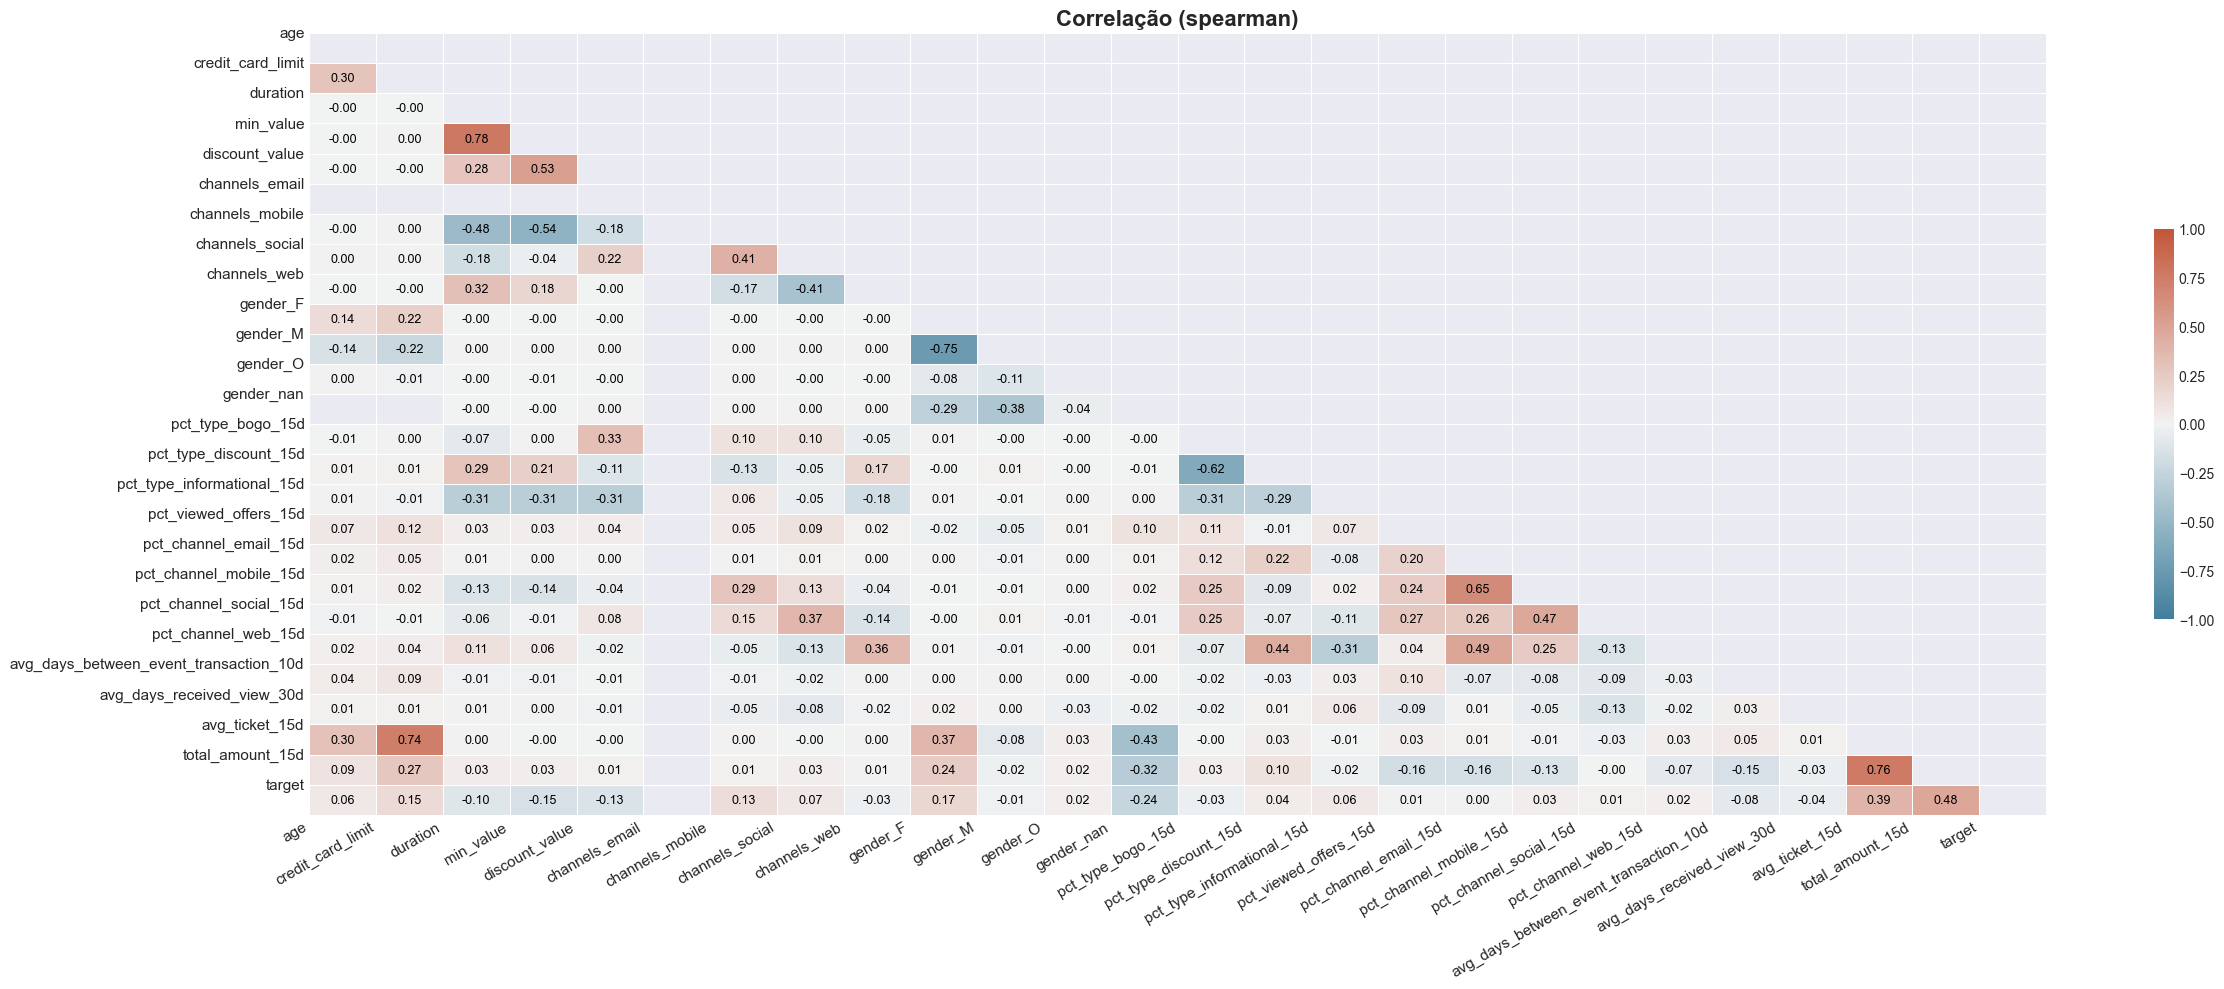

In [8]:
from src.plots import plot_corr
plot_corr(data_model[FEATURES + [TARGET]], method="spearman")

### **FEATURE SELECTION**

2025-05-12 17:54:54.555 | INFO     | src.utils:feature_selection:289 - Train AUC: 0.8871
2025-05-12 17:54:54.556 | INFO     | src.utils:feature_selection:290 - Valid AUC: 0.8749
2025-05-12 17:55:00.134 | SUCCESS  | src.utils:feature_selection:315 - POSITIVE IMPORTANCE:
2025-05-12 17:55:00.135 | SUCCESS  | src.utils:feature_selection:317 - 0.064156: min_value
2025-05-12 17:55:00.135 | SUCCESS  | src.utils:feature_selection:317 - 0.061751: avg_ticket_15d
2025-05-12 17:55:00.135 | SUCCESS  | src.utils:feature_selection:317 - 0.048888: total_amount_15d
2025-05-12 17:55:00.135 | SUCCESS  | src.utils:feature_selection:317 - 0.032600: avg_days_between_event_transaction_10d
2025-05-12 17:55:00.136 | SUCCESS  | src.utils:feature_selection:317 - 0.018611: pct_viewed_offers_15d
2025-05-12 17:55:00.136 | SUCCESS  | src.utils:feature_selection:317 - 0.015691: pct_type_informational_15d
2025-05-12 17:55:00.136 | SUCCESS  | src.utils:feature_selection:317 - 0.010943: channels_social
2025-05-12 17:55:

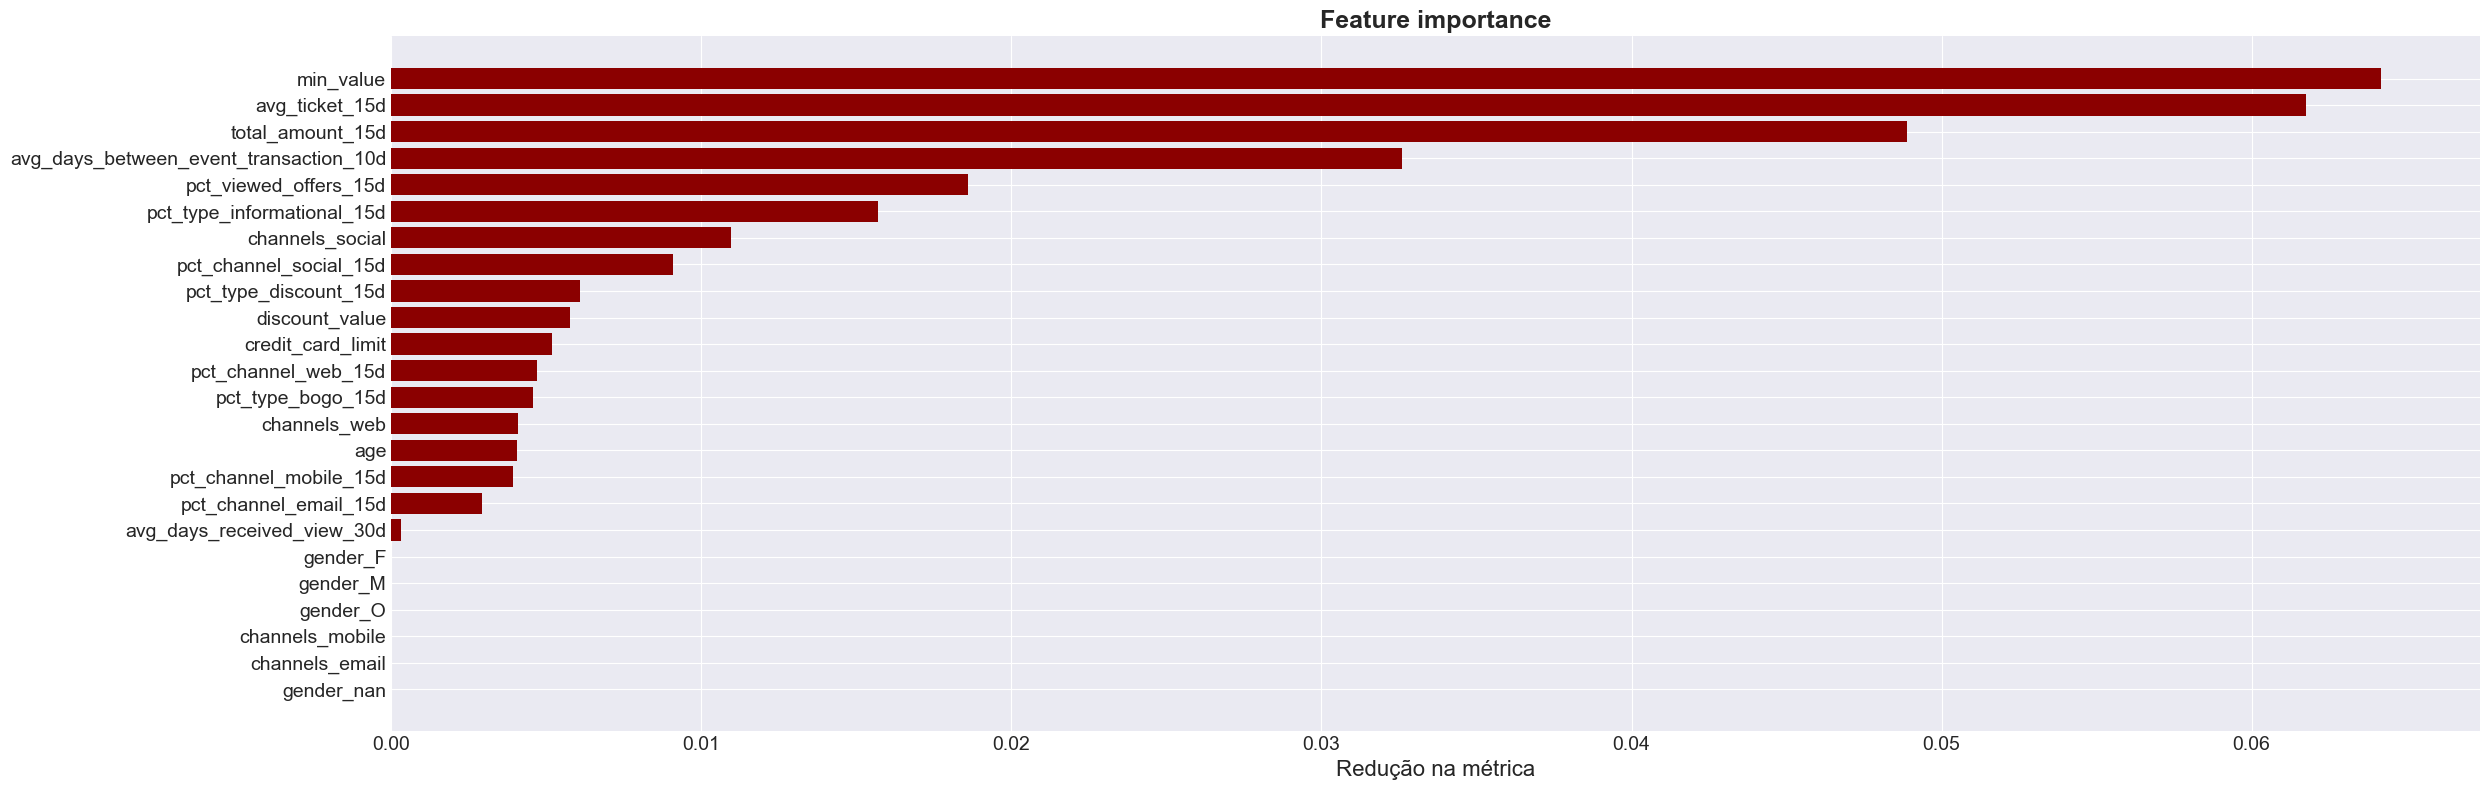

In [18]:
from src.utils import feature_selection
SELECTED_FEATURES = feature_selection(
    data=dtrain, features=FEATURES, target=TARGET
)

In [10]:
SELECTED_FEATURES

['avg_ticket_15d',
 'total_amount_15d',
 'avg_days_between_event_transaction_10d',
 'duration',
 'min_value',
 'pct_viewed_offers_15d',
 'pct_type_informational_15d',
 'channels_social',
 'pct_channel_social_15d',
 'pct_type_discount_15d',
 'discount_value',
 'pct_channel_web_15d',
 'channels_web',
 'credit_card_limit',
 'age',
 'pct_type_bogo_15d',
 'pct_channel_mobile_15d',
 'pct_channel_email_15d',
 'avg_days_received_view_30d']

### **MODEL**

#### **Optimization**

In [19]:
from src.hyperopt import RollingWindowOptimizer
optmizer = RollingWindowOptimizer(
    data=dtrain,
    features=SELECTED_FEATURES,
    target=TARGET,
    n_folds=5,
    trials=10
)
optmizer.run()

2025-05-12 17:56:30.722 | INFO     | src.hyperopt:run:24 -  Optimizing...
2025-05-12 17:56:31.516 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 1: Logloss=0.41982 (σ=0.00083) | AUC=0.87982 (σ=0.00011) | Brier=0.13069 (σ=0.00006)
2025-05-12 17:56:32.229 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 2: Logloss=0.44695 (σ=0.00108) | AUC=0.86384 (σ=0.00015) | Brier=0.13801 (σ=0.00007)
2025-05-12 17:56:32.843 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 3: Logloss=0.40532 (σ=0.00109) | AUC=0.89226 (σ=0.00011) | Brier=0.12376 (σ=0.00007)
2025-05-12 17:56:33.873 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 4: Logloss=0.37420 (σ=0.00037) | AUC=0.90658 (σ=0.00010) | Brier=0.11521 (σ=0.00005)
2025-05-12 17:56:34.305 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 5: Logloss=0.42790 (σ=0.00079) | AUC=0.87252 (σ=0.00011) | Brier=0.13433 (σ=0.00005)
2025-05-12 17:56:34.839 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 6: Logloss=0.45705 (σ=0.00096) | AUC=0.85478 (σ=0.00016) | Brier=0.14246 (σ=0.00008)
2025-05-

In [20]:
best_params = optmizer.best_params
best_params

{'max_depth': 4,
 'num_leaves': 12,
 'n_estimators': 120,
 'learning_rate': 0.1,
 'pos_bagging_fraction': 0.6345715916772514,
 'neg_bagging_fraction': 0.5592201843652373,
 'bagging_freq': 5}

#### **Traning**

In [33]:
from src.model import train_model

lgbm_calib, X_train, y_train, y_test, preds = train_model(
    dtrain=dtrain,
    dtest=dtest,
    features=SELECTED_FEATURES,
    target=TARGET, 
    params=best_params
)
results = dtest.assign(pred=preds)

2025-05-12 18:06:34.174 | INFO     | src.model:train_model:83 - Running model training...
2025-05-12 18:06:35.391 | INFO     | src.model:train_model:86 - Validation Performance: AUC: 0.9071 | Brier: 0.1146
2025-05-12 18:06:35.655 | SUCCESS  | src.model:train_model:102 - Test Model Performance: AUC 0.9081 | Brier: 0.1122


2025-05-12 18:44:12.419 | INFO     | src.utils:get_roc_auc_curve:377 -  Resulting metrics based on the optimal auc threshold:
2025-05-12 18:44:12.420 | INFO     | src.utils:get_roc_auc_curve:378 - Threshold=0.3333
2025-05-12 18:44:12.420 | INFO     | src.utils:get_roc_auc_curve:379 - AUC=0.8348
2025-05-12 18:44:12.420 | INFO     | src.utils:get_roc_auc_curve:380 - Precision=0.7142
2025-05-12 18:44:12.420 | INFO     | src.utils:get_roc_auc_curve:381 - Recall=0.8361


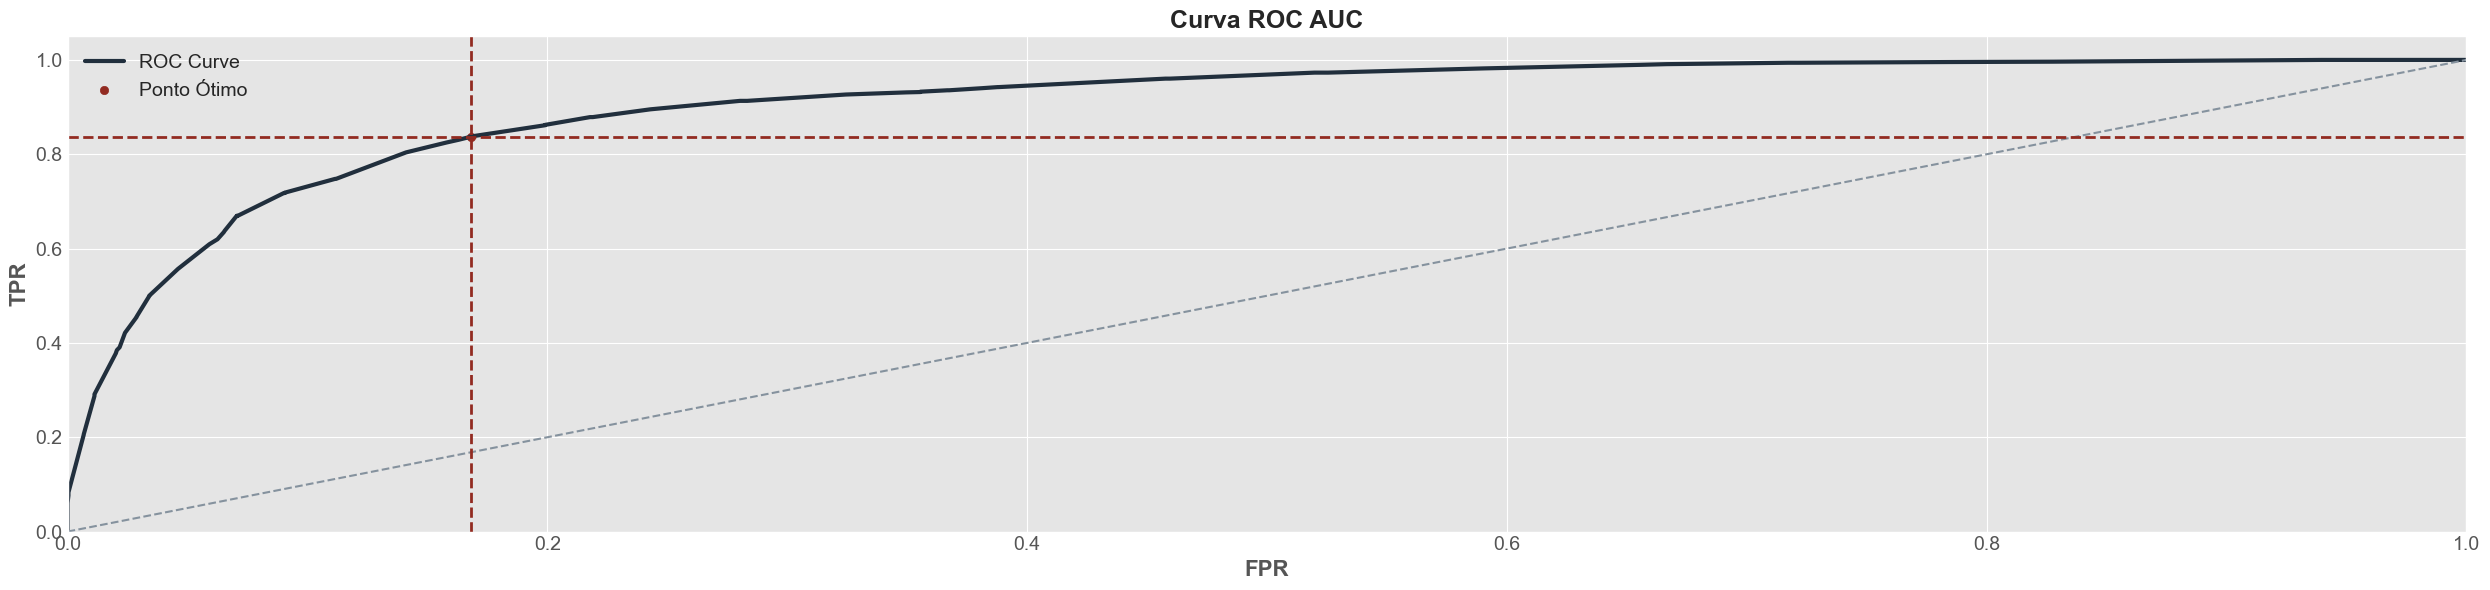

2025-05-12 18:44:12.502 | INFO     | src.utils:get_roc_auc_curve:387 - Percentual de oportunidades aproveitadas: 39.12%


In [92]:
from src.utils import get_roc_auc_curve
optimal_threshold = get_roc_auc_curve(y=y_test, y_pred=preds)

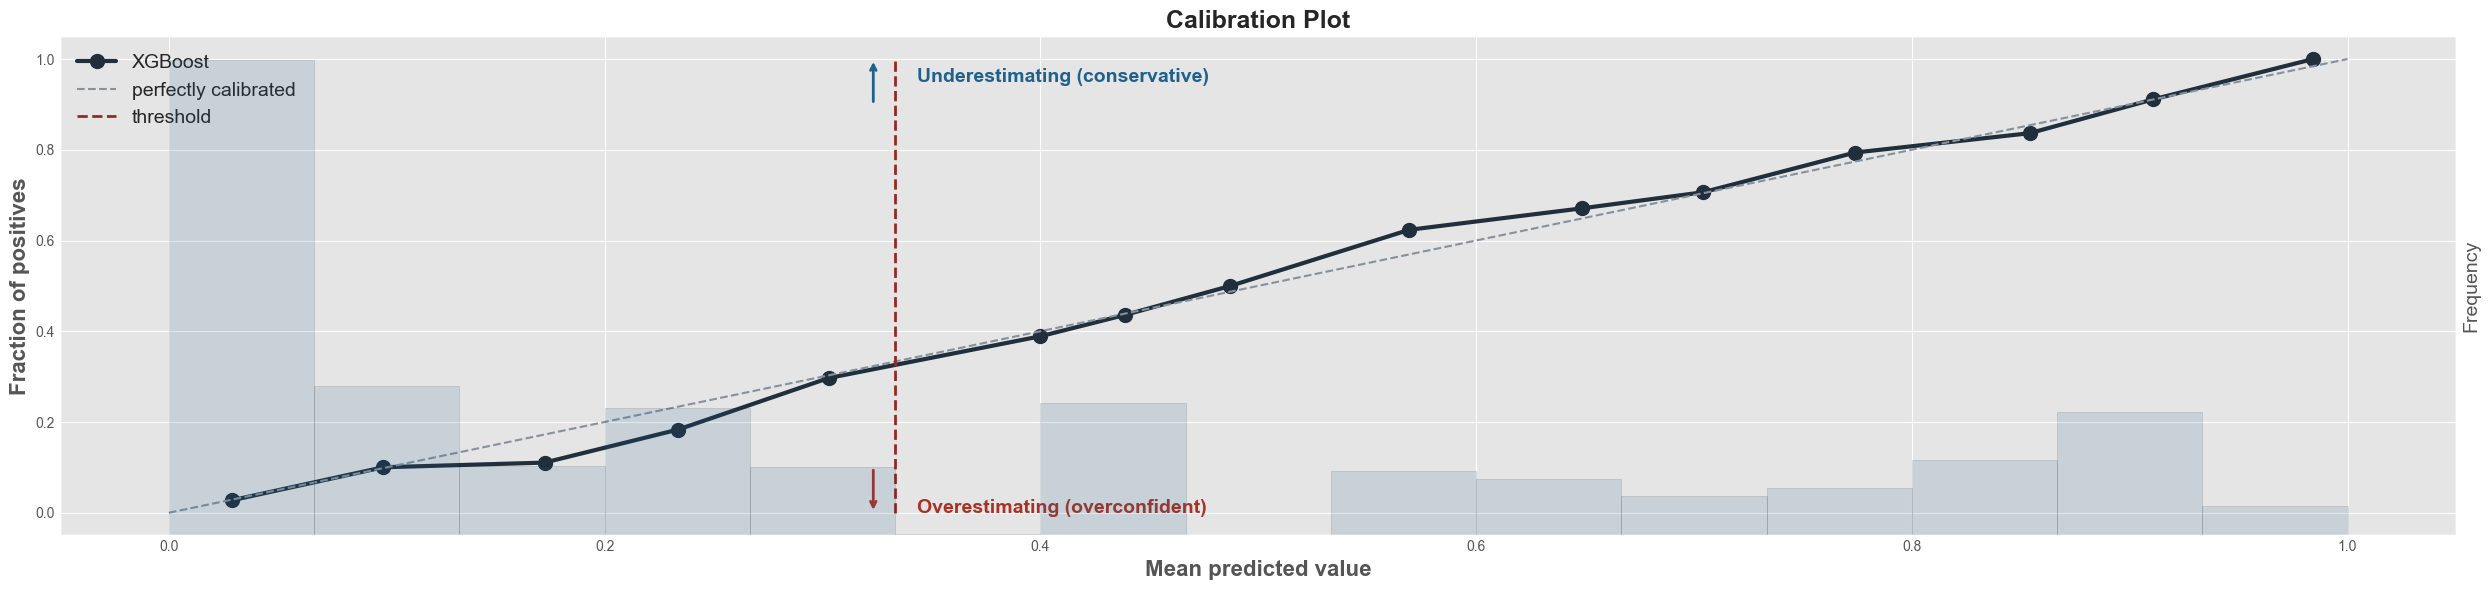

In [23]:
from src.plots import plot_calibration_curve
plot_calibration_curve(y=y_test, preds=preds, threshold=optimal_threshold)

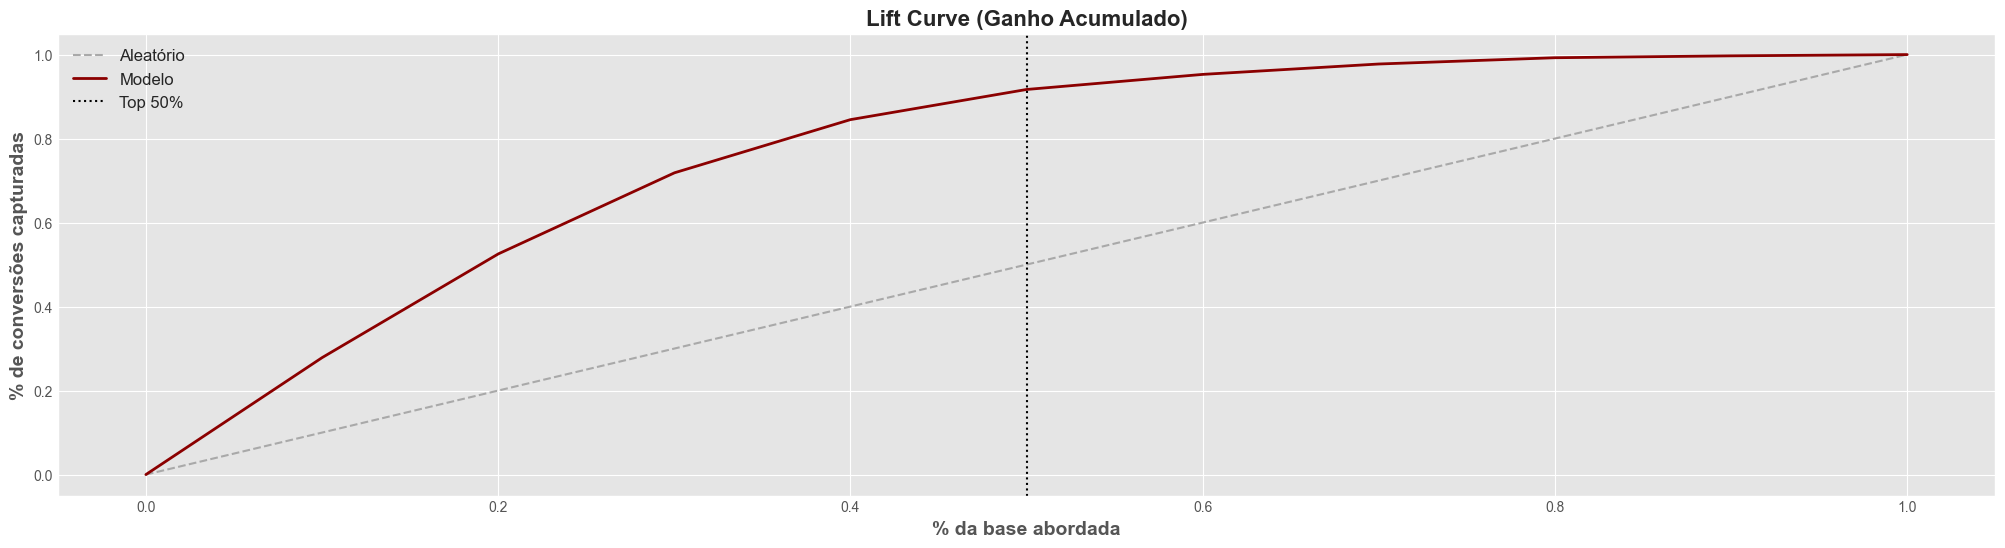

2025-05-12 18:59:07.512 | INFO     | src.plots:lift_curve_with_threshold:246 - Threshold para top 50% oportunidades: 0.2024


In [113]:
from src.plots import lift_curve_with_threshold
# Threshold com base em objetivo de negócio (ex: top-40% das oportunidades)
lift_threshold = lift_curve_with_threshold(y_test, preds, target_fraction=0.50)

In [124]:
from src.utils import precision_recall_at_threshold
precision_recall_at_threshold(y_true=y_test, y_proba=preds, threshold=lift_threshold)

2025-05-12 19:09:45.976 | INFO     | src.utils:precision_recall_at_threshold:274 - Precision@thr[0.20] = 0.5881
2025-05-12 19:09:45.976 | INFO     | src.utils:precision_recall_at_threshold:275 - Recall@thr[0.20] = 0.9266


In [ ]:
from src.utils import calculate_precision_recall_at_k
# Possibilidade de tomar decisões a partir das @k oportunidades de cliente-oferta
precision_at_k, recall_at_k = calculate_precision_recall_at_k(y_true=y_test, y_pred_proba=preds, k=1500)

2025-05-12 18:09:15.419 | INFO     | src.utils:calculate_precision_recall_at_k:261 - Precision@1500 = 0.7287
2025-05-12 18:09:15.419 | INFO     | src.utils:calculate_precision_recall_at_k:262 - Recall@1500 = 0.8181


In [ ]:
from src.utils import evaluate_potential
# Avalia o potencial aproveitado de combinações possíveis
evaluate_potential(results, optimal_threshold)

2025-05-12 19:03:02.758 | INFO     | src.utils:evaluate_potential:398 - % de combinações cliente-oferta testadas: 37.53%
2025-05-12 19:03:02.758 | INFO     | src.utils:evaluate_potential:399 - % de combinações cliente-oferta aprovadas: 39.02%
2025-05-12 19:03:02.759 | INFO     | src.utils:evaluate_potential:400 - % clientes com pelo menos uma oferta sugerida: 69.19%
2025-05-12 19:03:02.759 | INFO     | src.utils:evaluate_potential:401 - Potencial capturado das combinações cliente-oferta: 14.64%


In [ ]:
# Reduzir o threshold aumenta 
evaluate_potential(results, lift_threshold)

2025-05-12 19:01:24.090 | INFO     | src.utils:evaluate_potential:398 - % de combinações cliente-oferta testadas: 37.53%
2025-05-12 19:01:24.090 | INFO     | src.utils:evaluate_potential:399 - % de combinações cliente-oferta aprovadas: 49.33%
2025-05-12 19:01:24.090 | INFO     | src.utils:evaluate_potential:400 - % clientes com pelo menos uma oferta sugerida: 79.78%
2025-05-12 19:01:24.090 | INFO     | src.utils:evaluate_potential:401 - Potencial capturado das combinações cliente-oferta: 18.51%


#### **SHAP**

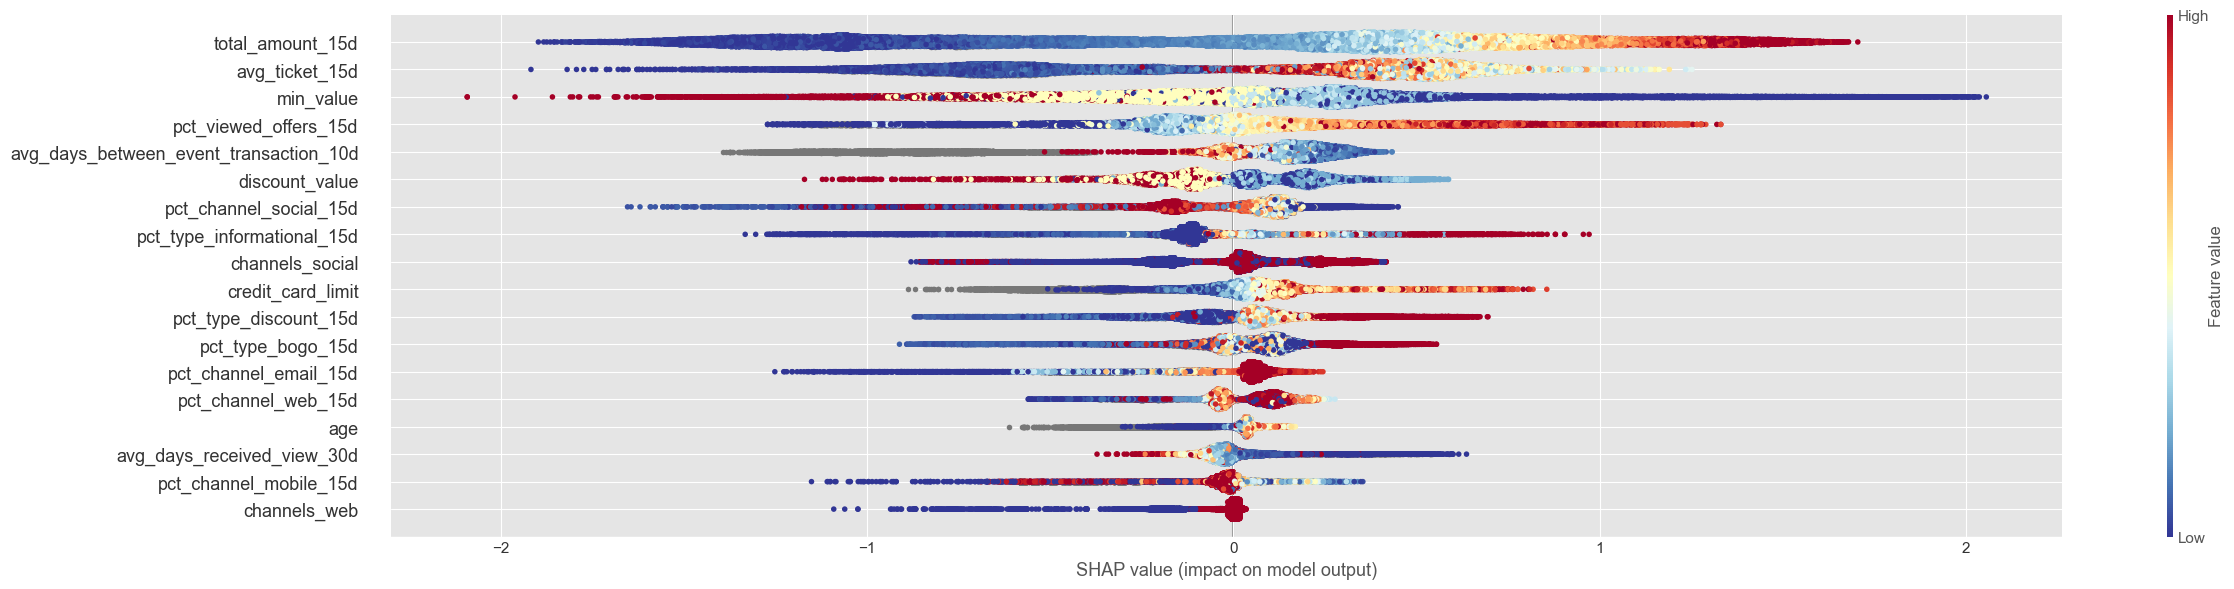

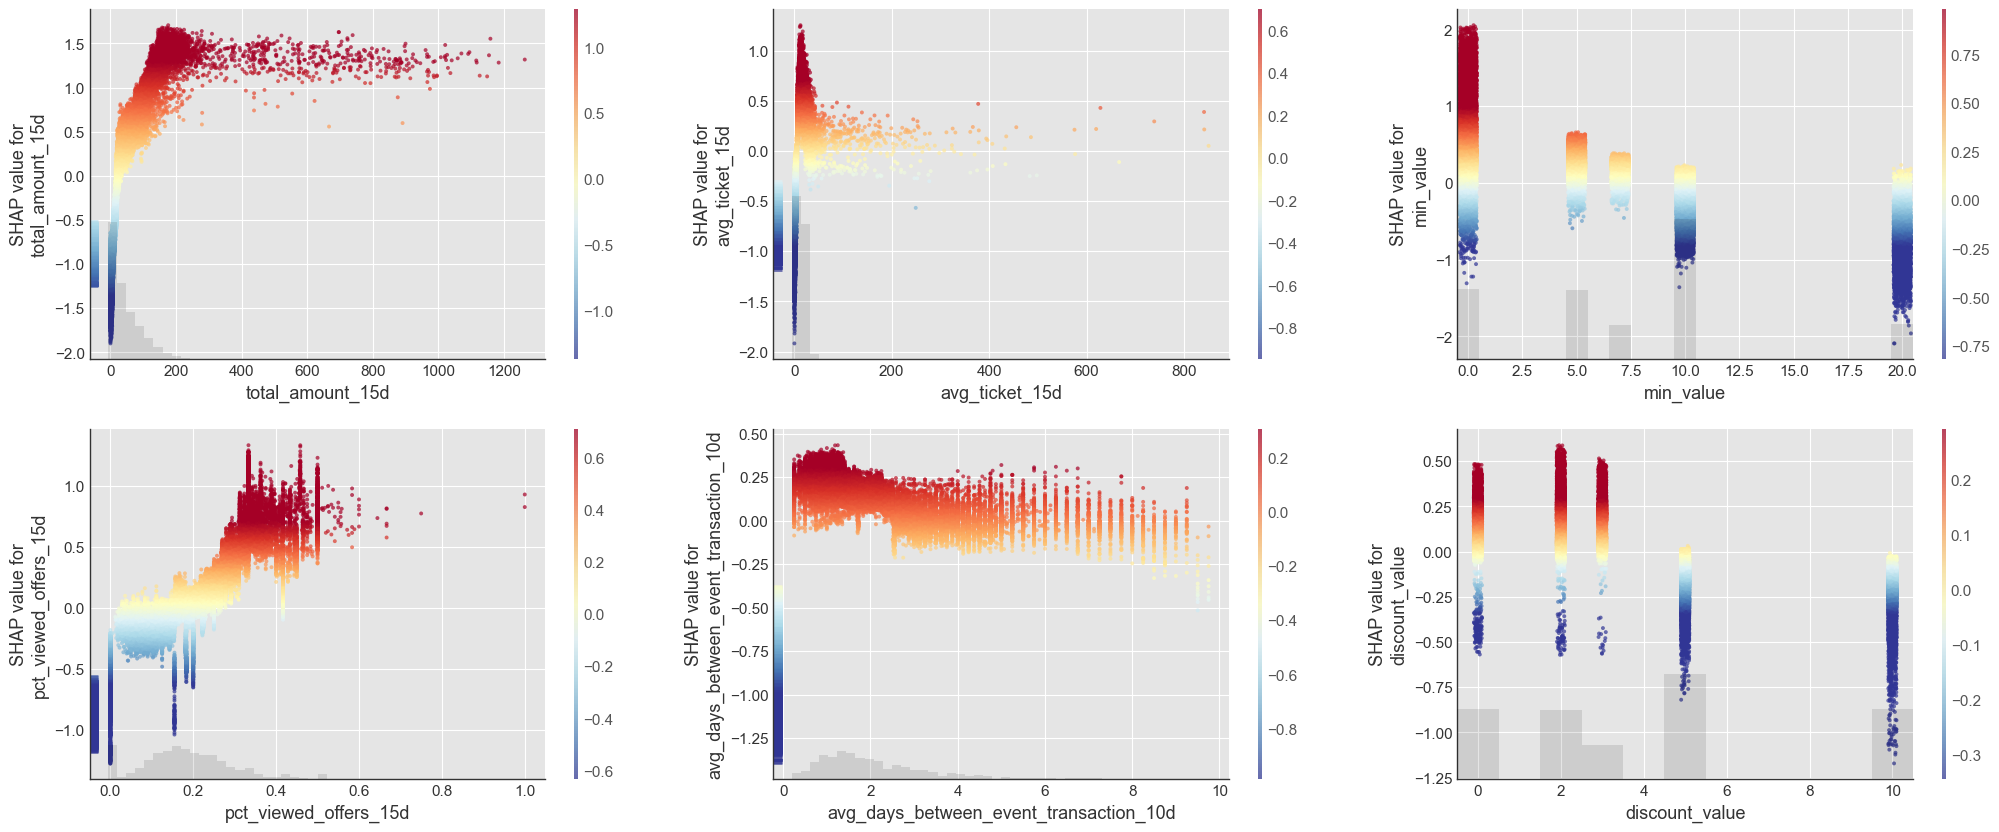

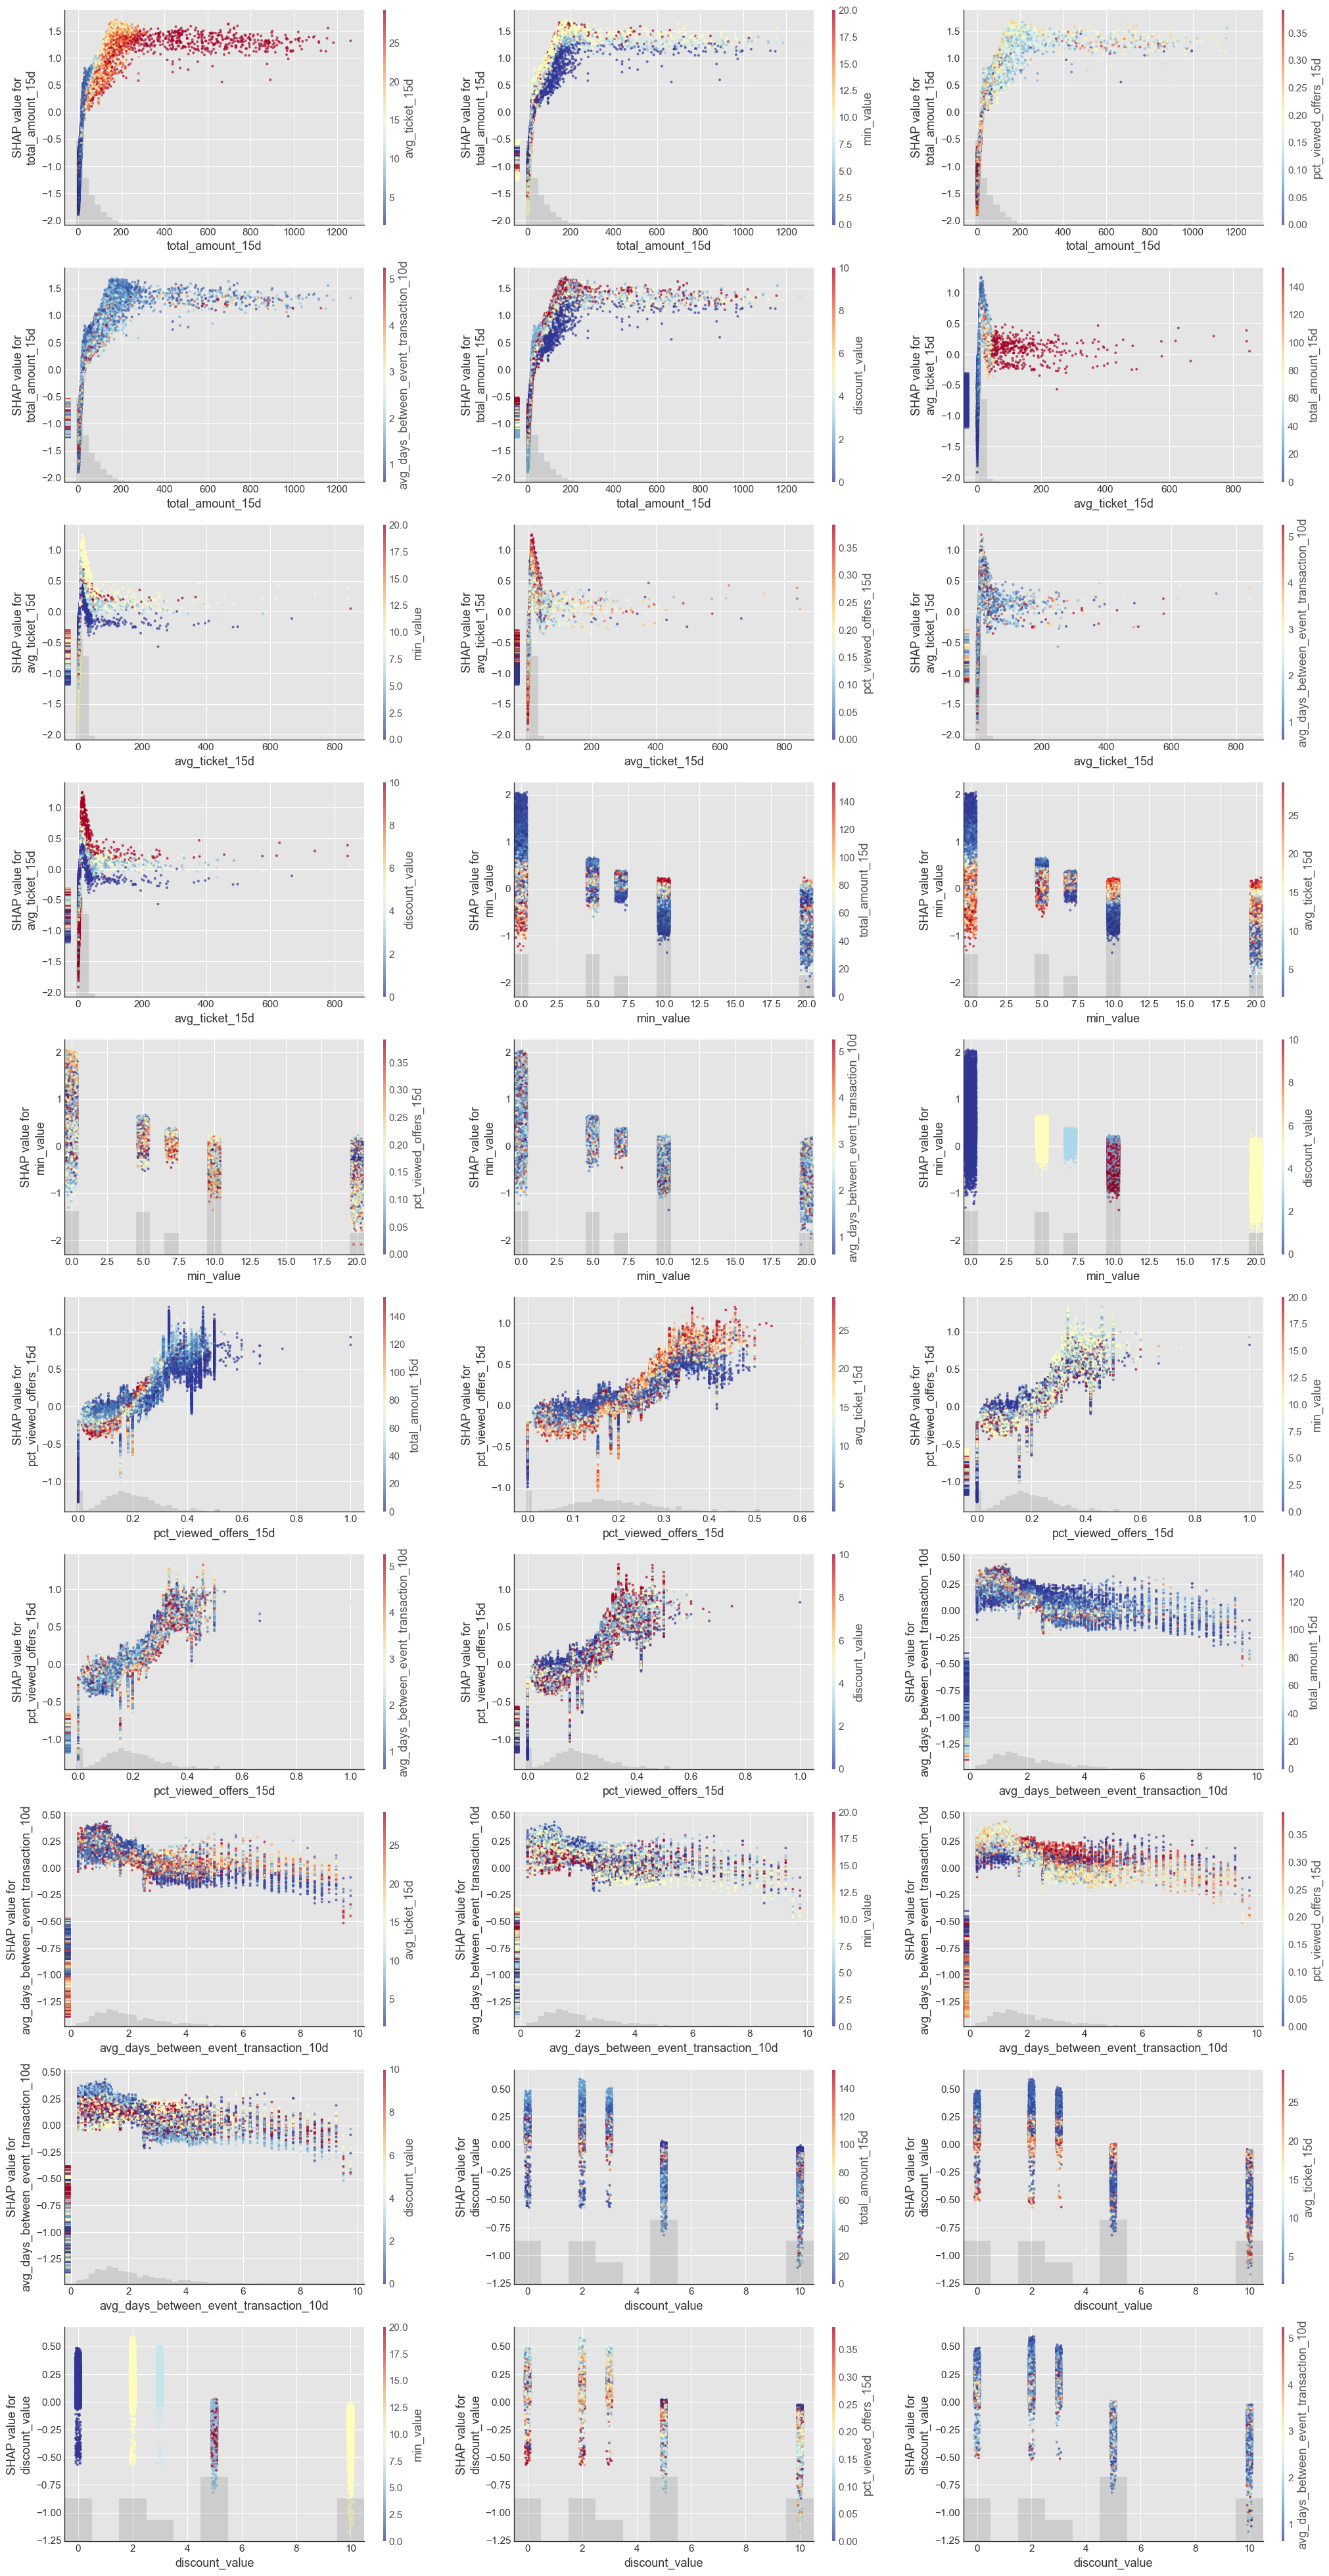

In [24]:
from src.plots import visualize_feature_importance
visualize_feature_importance(model=lgbm_calib, X=X_train, scatter_n_top_feats=6)